# DCGAN para imagenes pequeñas

### Importación de librerias

In [1]:
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
import tensorflow as tf
from tensorflow.keras.datasets.cifar10 import load_data
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Dropout
from matplotlib import pyplot

### Obtención de los datos

In [2]:
# example of loading the cifar10 dataset
from tensorflow.keras.datasets.cifar10 import load_data
# load the images into memory
(trainX, trainy), (testX, testy) = load_data()
# summarize the shape of the dataset
print("Train", trainX.shape, trainy.shape)
print("Test", testX.shape, testy.shape)

170500096/170498071 [==============================] - 4s 0us/step
Train (50000, 32, 32, 3) (50000, 1)
Test (10000, 32, 32, 3) (10000, 1)


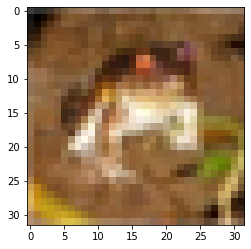

In [3]:
# plot raw pixel data
pyplot.imshow(trainX[0])

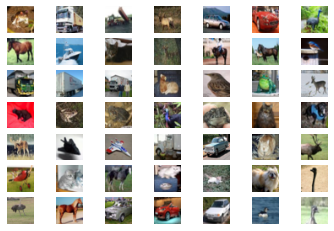

In [4]:
# example of loading and plotting the cifar10 dataset
from tensorflow.keras.datasets.cifar10 import load_data
from matplotlib import pyplot

# load the images into memory
(trainX, trainy), (testX, testy) = load_data()
# plot images from the training dataset
for i in range(49):
    # define subplot
    pyplot.subplot(7, 7, 1 + i)
    # turn off axis
    pyplot.axis("off")
    # plot raw pixel data
    pyplot.imshow(trainX[i])
pyplot.show()

### Definición del discriminador

In [13]:
def define_discriminator(in_shape=(32,32,3)):
    model = Sequential()
    # normal
    model.add(Conv2D(64, (3,3), padding="same", input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    # downsample
    model.add(Conv2D(128, (3,3), strides=(2,2), padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    # downsample
    model.add(Conv2D(128, (3,3), strides=(2,2), padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    # downsample
    model.add(Conv2D(256, (3,3), strides=(2,2), padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    # classifier
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation="sigmoid"))
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
    return model

### Definición del modelo generador

In [6]:
# define the standalone generator model
def define_generator(latent_dim):
    model = Sequential()
    # foundation for 4x4 image
    n_nodes = 256 * 4 * 4
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((4, 4, 256)))
    # upsample to 8x8
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 16x16
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 32x32
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    # output layer
    model.add(Conv2D(3, (3,3), activation="tanh", padding="same"))
    return model

### Definición del Modelo GAN

In [7]:
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(g_model)
    # add the discriminator
    model.add(d_model)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss="binary_crossentropy", optimizer=opt)
    return model

### Preparación de datos

In [8]:
def load_real_samples():
    # load cifar10 dataset
    (trainX, _), (_, _) = load_data()
    # convert from unsigned ints to floats
    X = trainX.astype("float32")
    # scale from [0,255] to [-1,1]
    X = (X - 127.5) / 127.5
    return X

### Generación de Datos inputs

In [9]:
# select real samples
def generate_real_samples(dataset, n_samples):
    # choose random instances
    ix = randint(0, dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[ix]
    # generate ✬real✬ class labels (1)
    y = ones((n_samples, 1))
    return X, y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = g_model.predict(x_input)
    # create "fake" class labels (0)
    y = zeros((n_samples, 1))
    return X, y

### Funciones auxiliares

In [10]:
# create and save a plot of generated images
def save_plot(examples, epoch, n=7):
    # scale from [-1,1] to [0,1]
    examples = (examples + 1) / 2.0
    # plot images
    for i in range(n * n):
        # define subplot
        pyplot.subplot(n, n, 1 + i)
        # turn off axis
        pyplot.axis("off")
        # plot raw pixel data
        pyplot.imshow(examples[i])
    # save plot to file
    filename = "generated_plot_e%03d.png" % (epoch+1)
    pyplot.savefig(filename)
    pyplot.close()


# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=150):
    # prepare real samples
    X_real, y_real = generate_real_samples(dataset, n_samples)
    # evaluate discriminator on real examples
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    # evaluate discriminator on fake examples
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    # summarize discriminator performance
    print(">Accuracy real: %.0f%%, fake: %.0f%%" % (acc_real*100, acc_fake*100))
    # save plot
    save_plot(x_fake, epoch)
    # save the generator model tile file
    filename = "generator_model_%03d.h5" % (epoch+1)
    g_model.save(filename)

### Entrenamiento del GAN

In [11]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=200, n_batch=128):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            # get randomly selected "real" samples
            X_real, y_real = generate_real_samples(dataset, half_batch)
            # update discriminator model weights
            d_loss1, _ = d_model.train_on_batch(X_real, y_real)
            # generate ✬fake✬ examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # update discriminator model weights
            d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
            # prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = ones((n_batch, 1))
            # update the generator via the discriminator✬s error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            # summarize loss on this batch
            print(">%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f" %
            (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
            # evaluate the model performance, sometimes
        if (i+1) % 10 == 0:
            summarize_performance(i, g_model, d_model, dataset, latent_dim)

In [14]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

Se han truncado las últimas 5000 líneas del flujo de salida.
>188, 74/390, d1=0.420, d2=0.622 g=1.341
>188, 75/390, d1=0.539, d2=0.605 g=1.254
>188, 76/390, d1=0.683, d2=0.420 g=1.341
>188, 77/390, d1=0.532, d2=0.396 g=1.327
>188, 78/390, d1=0.488, d2=0.610 g=1.351
>188, 79/390, d1=0.547, d2=0.606 g=1.393
>188, 80/390, d1=0.496, d2=0.419 g=1.402
>188, 81/390, d1=0.535, d2=0.462 g=1.299
>188, 82/390, d1=0.506, d2=0.476 g=1.458
>188, 83/390, d1=0.521, d2=0.388 g=1.370
>188, 84/390, d1=0.445, d2=0.483 g=1.354
>188, 85/390, d1=0.583, d2=0.599 g=1.338
>188, 86/390, d1=0.390, d2=0.483 g=1.429
>188, 87/390, d1=0.648, d2=0.437 g=1.457
>188, 88/390, d1=0.545, d2=0.522 g=1.381
>188, 89/390, d1=0.574, d2=0.459 g=1.345
>188, 90/390, d1=0.522, d2=0.481 g=1.435
>188, 91/390, d1=0.579, d2=0.543 g=1.324
>188, 92/390, d1=0.467, d2=0.558 g=1.313
>188, 93/390, d1=0.512, d2=0.486 g=1.335
>188, 94/390, d1=0.550, d2=0.479 g=1.376
>188, 95/390, d1=0.564, d2=0.498 g=1.429
>188, 96/390, d1=0.486, d2=0.468 g=1.

### Uso del modelo generador

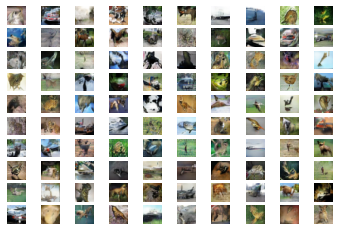

In [15]:
from tensorflow.keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot
# generate points in latent space as input for the generator

def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

# create and save a plot of generated images
def save_plot(examples, n):
    # plot images
    for i in range(n * n):
        # define subplot
        pyplot.subplot(n, n, 1 + i)
        # turn off axis
        pyplot.axis("off")
        # plot raw pixel data
        pyplot.imshow(examples[i, :, :])
    pyplot.show()


# load model
model = load_model("generator_model_200.h5")
# generate images
latent_points = generate_latent_points(100, 100)
# generate images
X = model.predict(latent_points)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
save_plot(X, 10)

### Ejemplo para un sólo dato generado

You can
experiment with generating different points in this space and see what types of images they
generate. The example below generates a single image using a vector of all 0.75 values.

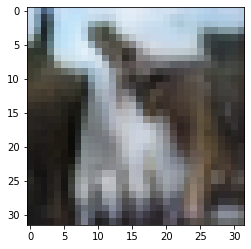

In [16]:
# example of generating an image for a specific point in the latent space
from tensorflow.keras.models import load_model
from numpy import asarray
from matplotlib import pyplot

# load model
model = load_model("generator_model_200.h5")
# all 0s
vector = asarray([[0.75 for _ in range(100)]])
# generate image
X = model.predict(vector)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
pyplot.imshow(X[0, :, :])
pyplot.show()